<h1><center><font size="6">Credit Card Fraud Detection Predictive Models</font></center></h1>


<center><img src="https://images.unsplash.com/photo-1563013544-824ae1b704d3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80" width="600"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Check the data</a>  
    - <a href='#41'>Glimpse the data</a>  
    - <a href='#42'>Check missing data</a>
    - <a href='#43'>Check data unbalance</a>
- <a href='#5'>Data exploration</a>
- <a href='#6'>Predictive models</a>  
    - <a href='#61'>RandomForrestClassifier</a> 
    - <a href='#62'>AdaBoostClassifier</a>     
    - <a href='#63'>CatBoostClassifier</a> 
    - <a href='#64'>XGBoost</a> 
    - <a href='#65'>LightGBM</a> 
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>


# <a id="1">Introduction</a>  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



# <a id="2">Load packages</a>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import pickle
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

# if(IS_LOCAL):
#     PATH="../input/credit-card-fraud-detection"
# else:
#     PATH="../input"
# print(os.listdir(PATH))

In [43]:
# !pip install catboost
# !pip install xgboost
# !pip install lightgbm

# <a id="3">Read the data</a>

In [3]:
data_df = pd.read_csv("creditcard.csv")
# Create a renaming dictionary
rename_dict = {'Time': 'Transaction_Time', 
               'Amount': 'Transaction_Amount', 
               'Class': 'Fraud_Label'}

# Rename V1 to V28 as Feature_1 to Feature_28
rename_dict.update({f'V{i}': f'Transaction_{i}' for i in range(1, 29)})

# Apply renaming
data_df.rename(columns=rename_dict, inplace=True)

# Display new column names
data_df

,Transaction_Time,Transaction_1,Transaction_2,Transaction_3,Transaction_4,Transaction_5,Transaction_6,Transaction_7,Transaction_8,Transaction_9,Transaction_10,Transaction_11,Transaction_12,Transaction_13,Transaction_14,Transaction_15,Transaction_16,Transaction_17,Transaction_18,Transaction_19,Transaction_20,Transaction_21,Transaction_22,Transaction_23,Transaction_24,Transaction_25,Transaction_26,Transaction_27,Transaction_28,Transaction_Amount,Fraud_Label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# <a id="4">Check the data</a>

In [4]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


## <a id="41">Glimpse the data</a>

We start by looking to the data features (first 5 rows).

In [5]:
data_df.head()

,Transaction_Time,Transaction_1,Transaction_2,Transaction_3,Transaction_4,Transaction_5,Transaction_6,Transaction_7,Transaction_8,Transaction_9,Transaction_10,Transaction_11,Transaction_12,Transaction_13,Transaction_14,Transaction_15,Transaction_16,Transaction_17,Transaction_18,Transaction_19,Transaction_20,Transaction_21,Transaction_22,Transaction_23,Transaction_24,Transaction_25,Transaction_26,Transaction_27,Transaction_28,Transaction_Amount,Fraud_Label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's look into more details to the data.

In [6]:
data_df.describe()

,Transaction_Time,Transaction_1,Transaction_2,Transaction_3,Transaction_4,Transaction_5,Transaction_6,Transaction_7,Transaction_8,Transaction_9,Transaction_10,Transaction_11,Transaction_12,Transaction_13,Transaction_14,Transaction_15,Transaction_16,Transaction_17,Transaction_18,Transaction_19,Transaction_20,Transaction_21,Transaction_22,Transaction_23,Transaction_24,Transaction_25,Transaction_26,Transaction_27,Transaction_28,Transaction_Amount,Fraud_Label
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Looking to the **Time** feature, we can confirm that the data contains **284,807** transactions, during 2 consecutive days (or **172792** seconds).

## <a id="42">Check missing data</a>  

Let's check if there is any missing data.

In [7]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Transaction_Time,Transaction_16,Transaction_Amount,Transaction_28,Transaction_27,Transaction_26,Transaction_25,Transaction_24,Transaction_23,Transaction_22,Transaction_21,Transaction_20,Transaction_19,Transaction_18,Transaction_17,Transaction_15,Transaction_1,Transaction_14,Transaction_13,Transaction_12,Transaction_11,Transaction_10,Transaction_9,Transaction_8,Transaction_7,Transaction_6,Transaction_5,Transaction_4,Transaction_3,Transaction_2,Fraud_Label
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# # First, set all fraud labels to 0
# data_df['Manual_Fraud_Label'] = 0

# # Now, mark users as fraud if any of their transactions exceed 1000
# users_with_large_txn = data_df[data_df['Transaction_Amount'] > 1000]['User_ID'].unique()

# # Update manual fraud label
# data_df.loc[data_df['User_ID'].isin(users_with_large_txn), 'Manual_Fraud_Label'] = 1

data_df['Fraud_Label'] = data_df['Transaction_Amount'].apply(lambda x: 1 if x > 1000 else 0)
data_df.head()

,Transaction_Time,Transaction_1,Transaction_2,Transaction_3,Transaction_4,Transaction_5,Transaction_6,Transaction_7,Transaction_8,Transaction_9,Transaction_10,Transaction_11,Transaction_12,Transaction_13,Transaction_14,Transaction_15,Transaction_16,Transaction_17,Transaction_18,Transaction_19,Transaction_20,Transaction_21,Transaction_22,Transaction_23,Transaction_24,Transaction_25,Transaction_26,Transaction_27,Transaction_28,Transaction_Amount,Fraud_Label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data_df.to_csv("creditcard_transaction.csv")

There is no missing data in the entire dataset.

## <a id="43">Data unbalance</a>

Let's check data unbalance with respect with *target* value, i.e. **Class**.

In [10]:
temp = data_df["Fraud_Label"].value_counts()
df = pd.DataFrame({'Fraud_Label': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Fraud_Label'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Fraud_Label', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Fraud_Label')

Only **492** (or **0.172%**) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable **Class**.

# <a id="5">Data exploration</a>

## Transactions in time

In [12]:
class_0 = data_df.loc[data_df['Fraud_Label'] == 0]["Transaction_Time"]
class_1 = data_df.loc[data_df['Fraud_Label'] == 1]["Transaction_Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Transaction_Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [13]:
data_df['Hour'] = data_df['Transaction_Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Fraud_Label'])['Transaction_Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.00,986.31,3940,211193.77,53.602480,12.990,1.167075e+04
1,0.0,1,1015.61,7712.43,23,45908.10,1996.004348,1447.710,2.209708e+06
2,1.0,0,0.00,1000.00,2206,130994.84,59.381160,22.615,1.133416e+04
3,1.0,1,1129.10,1769.69,11,15110.85,1373.713636,1326.000,5.293415e+04
4,2.0,0,0.00,950.82,1566,87322.87,55.761731,16.990,1.216650e+04


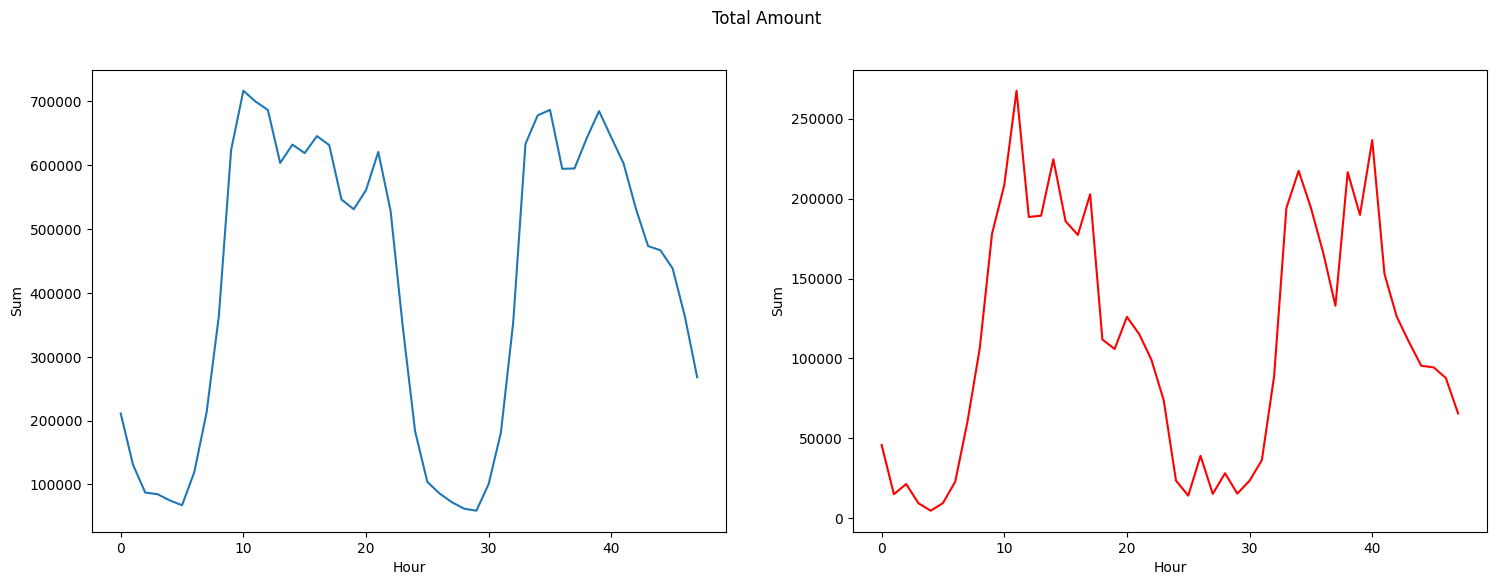

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

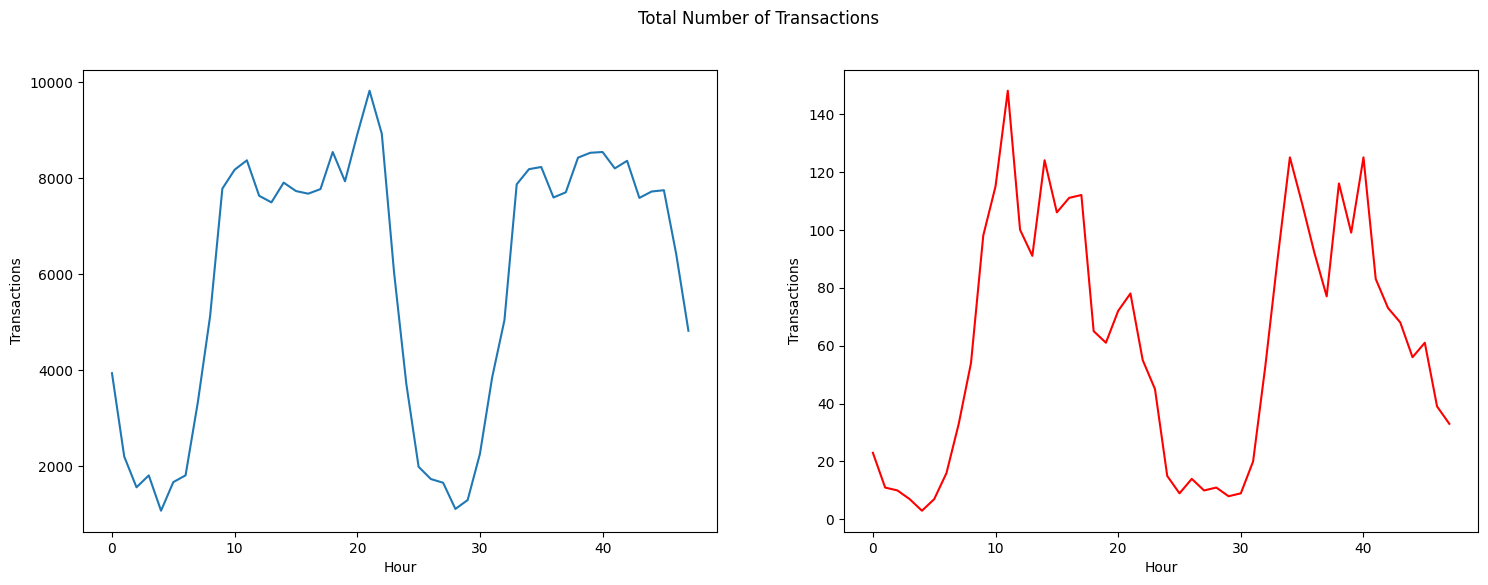

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

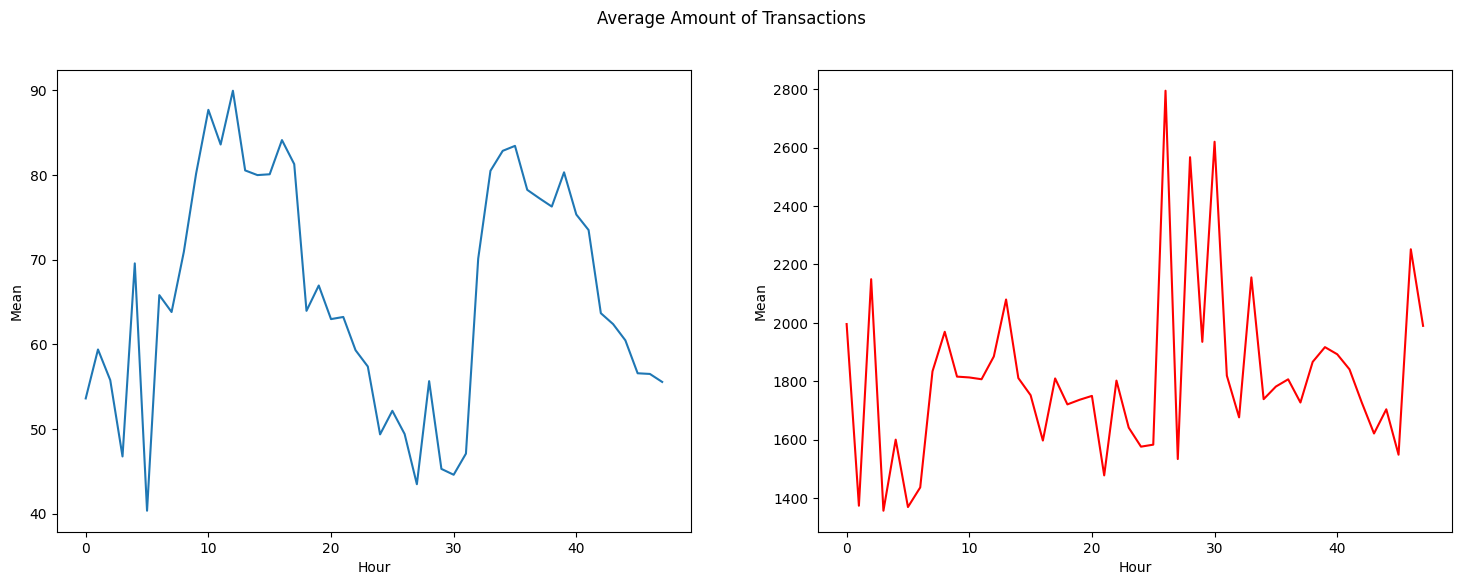

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

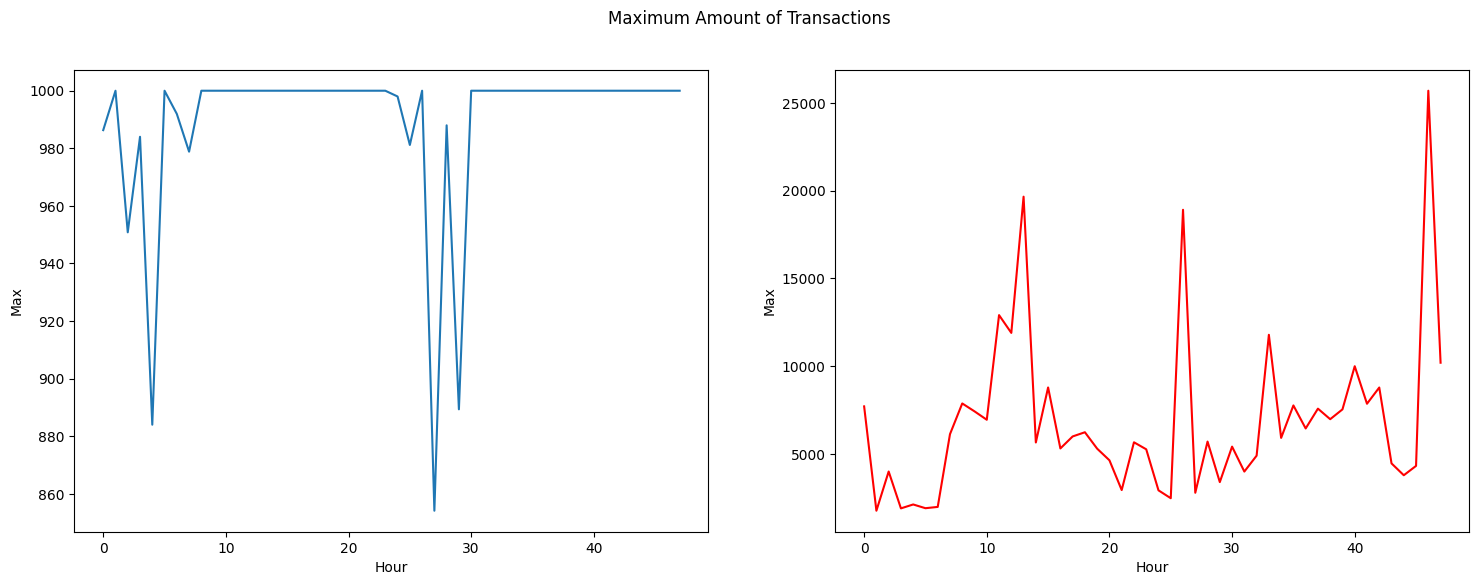

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

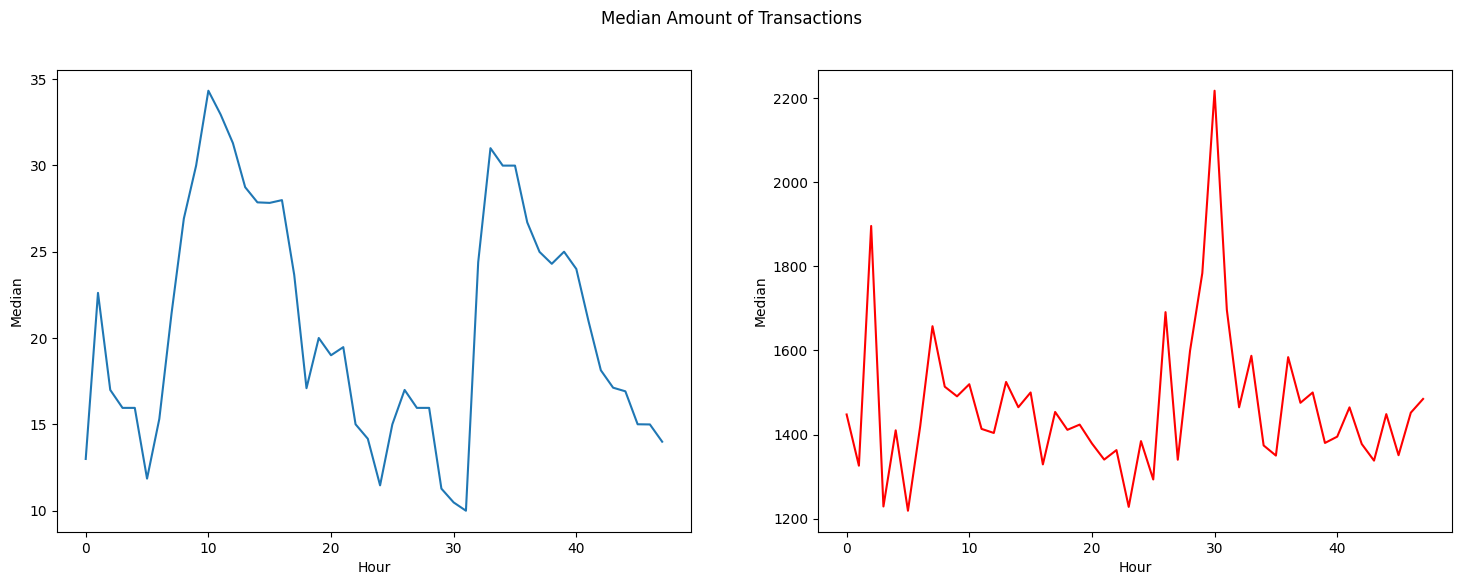

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

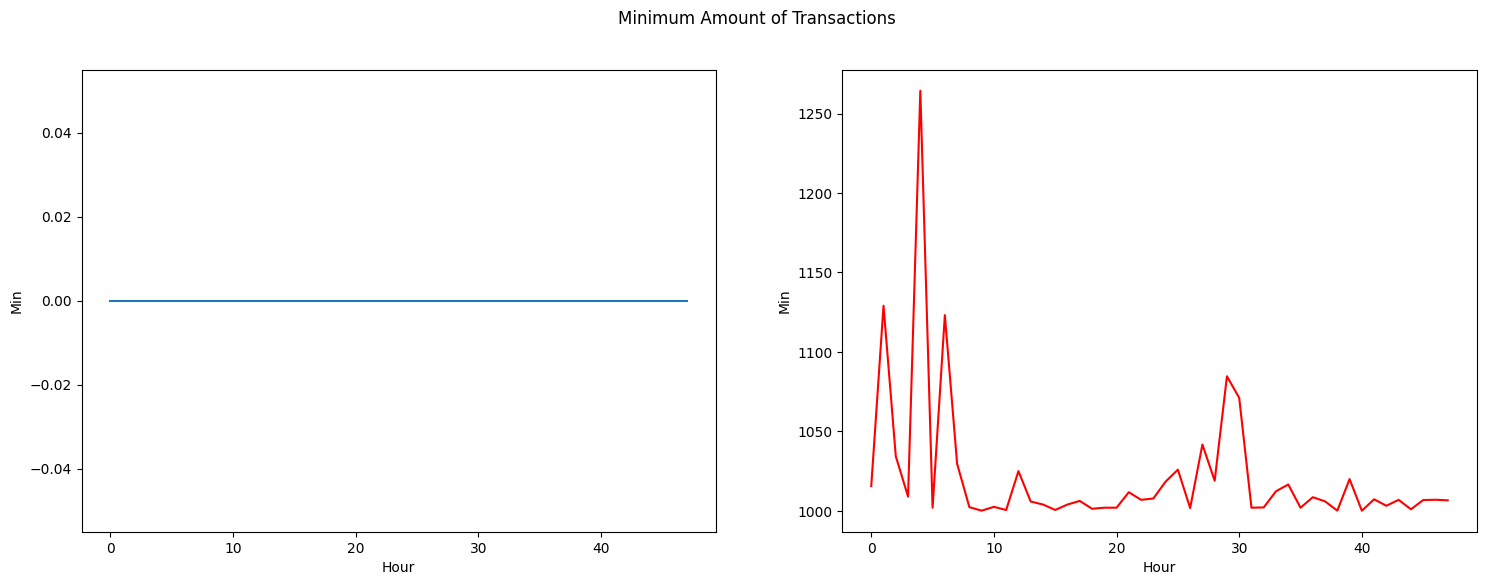

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

## Transactions amount

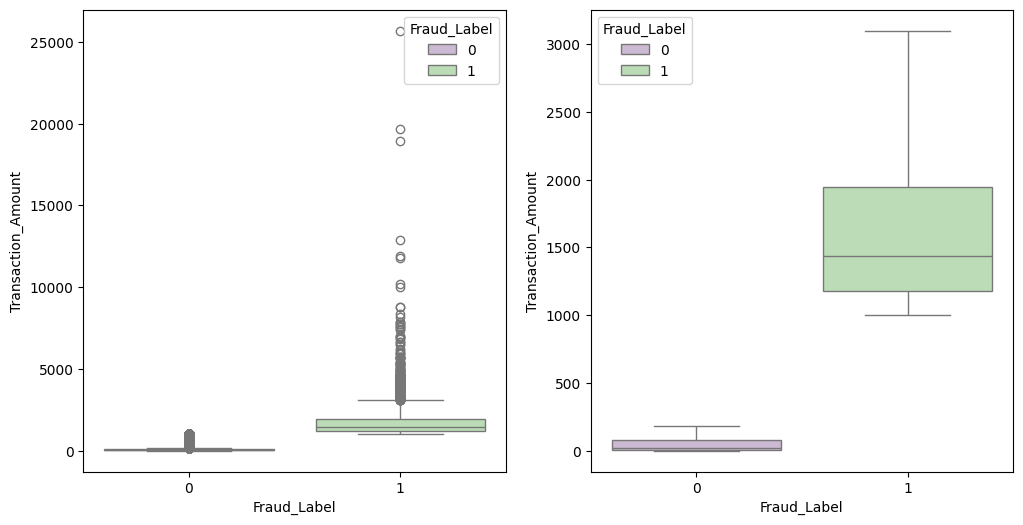

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Fraud_Label", y="Transaction_Amount", hue="Fraud_Label",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Fraud_Label", y="Transaction_Amount", hue="Fraud_Label",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [15]:
tmp = data_df[['Transaction_Amount','Fraud_Label']].copy()
class_0 = tmp.loc[tmp['Fraud_Label'] == 0]['Transaction_Amount']
class_1 = tmp.loc[tmp['Fraud_Label'] == 1]['Transaction_Amount']
class_0.describe()

count    281867.000000
mean         70.413635
std         127.958693
min           0.000000
25%           5.460000
50%          21.160000
75%          74.900000
max        1000.000000
Name: Transaction_Amount, dtype: float64

In [16]:
class_1.describe()

count     2940.000000
mean      1807.928565
std       1226.099302
min       1000.100000
25%       1177.960000
50%       1435.250000
75%       1946.842500
max      25691.160000
Name: Transaction_Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [17]:
fraud = data_df.loc[data_df['Fraud_Label'] == 1]

trace = go.Scatter(
    x = fraud['Transaction_Time'],y = fraud['Transaction_Amount'],
    name="Transaction_Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Transaction_Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Transaction_Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Transaction_Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features correlation

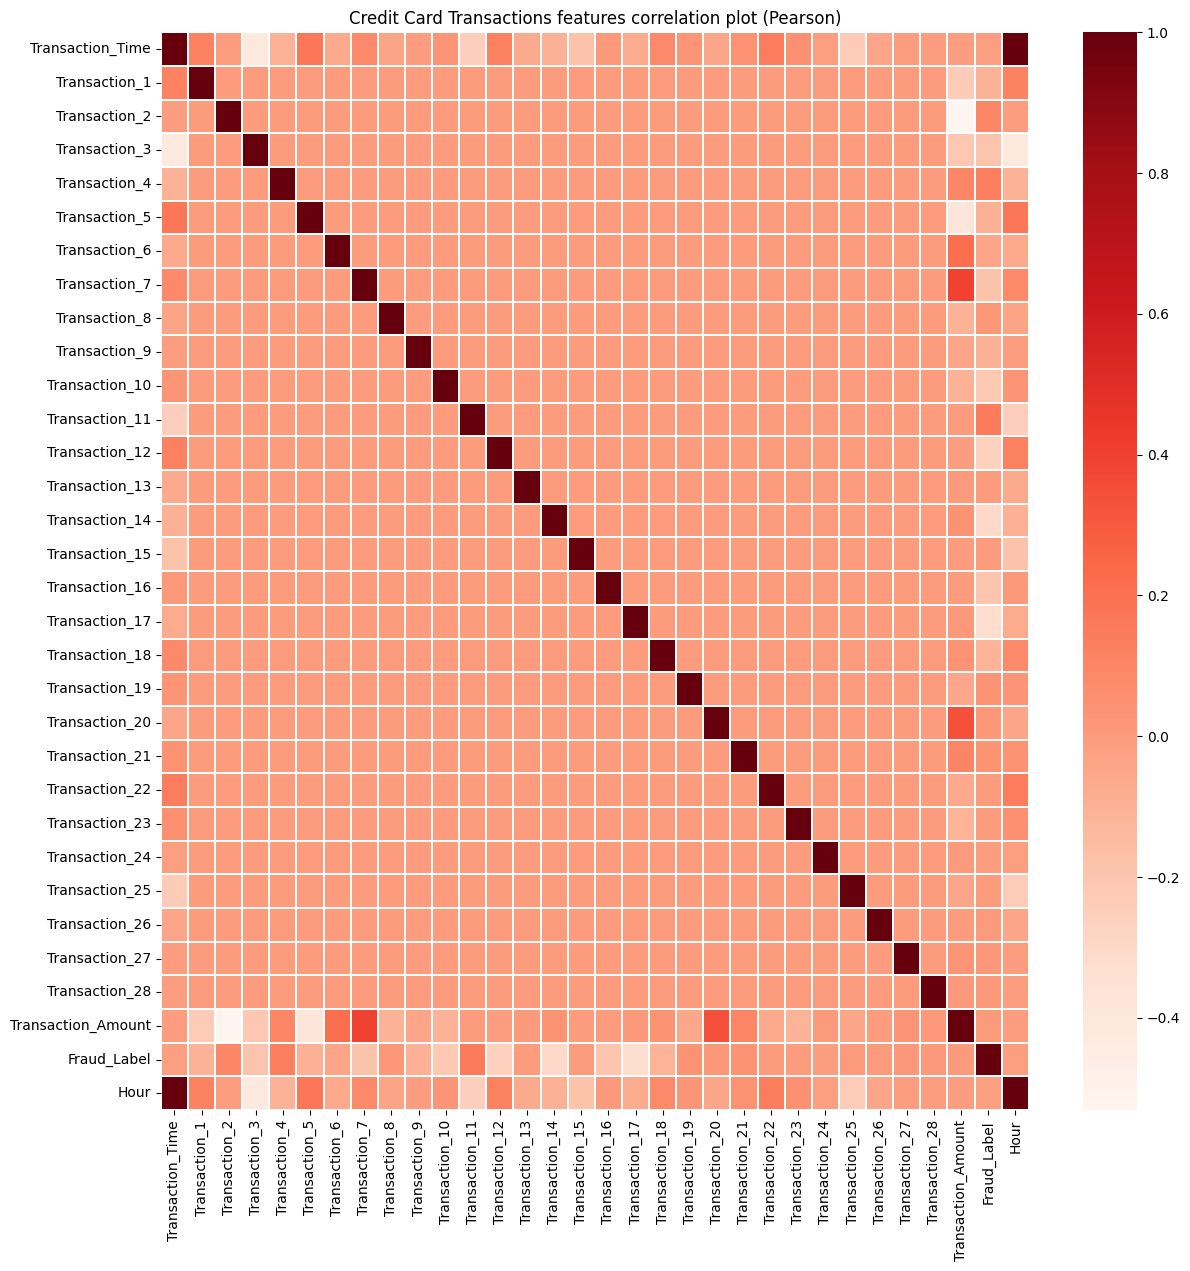

In [25]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features **V1**-**V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V1** and **V5**).


Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

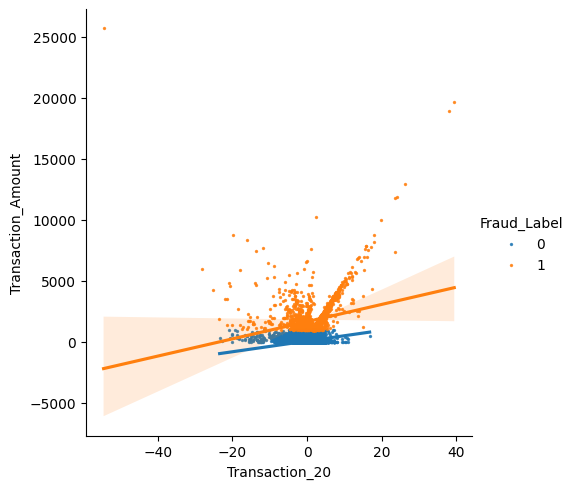

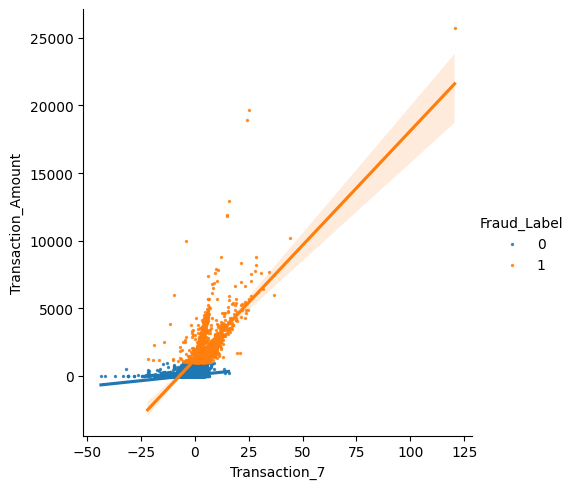

In [18]:
s = sns.lmplot(x='Transaction_20', y='Transaction_Amount',data=data_df, hue='Fraud_Label', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='Transaction_7', y='Transaction_Amount',data=data_df, hue='Fraud_Label', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for **Class = 0** have a positive slope, whilst the regression line for **Class = 1** have a smaller positive slope).

Let's plot now the inverse correlated values.

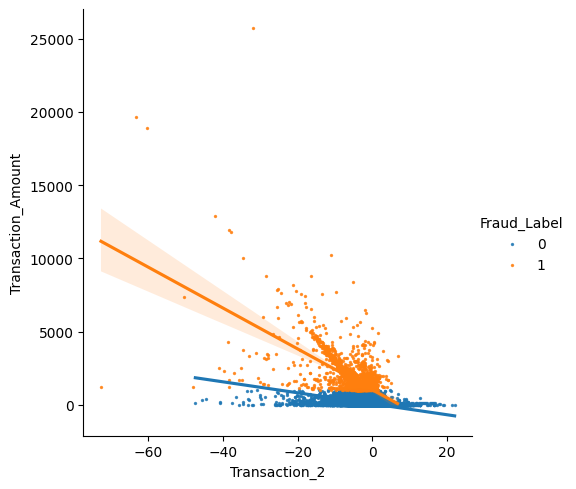

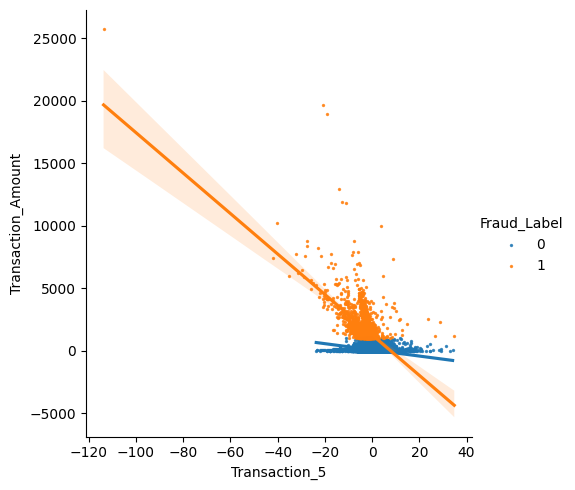

In [25]:
s = sns.lmplot(x='Transaction_2', y='Transaction_Amount',data=data_df, hue='Fraud_Label', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='Transaction_5', y='Transaction_Amount',data=data_df, hue='Fraud_Label', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).


## Features density plot

C:\Users\NIKITA\AppData\Local\Temp\ipykernel_6232\2443043882.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\NIKITA\AppData\Local\Temp\ipykernel_6232\2443043882.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\NIKITA\AppData\Local\Temp\ipykernel_6232\2443043882.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


C:\Users\NIKITA\AppData\Local\Temp\ipykernel_6232\2443043882.py:15: UserWarning:



The `bw` paramet

<Figure size 640x480 with 0 Axes>

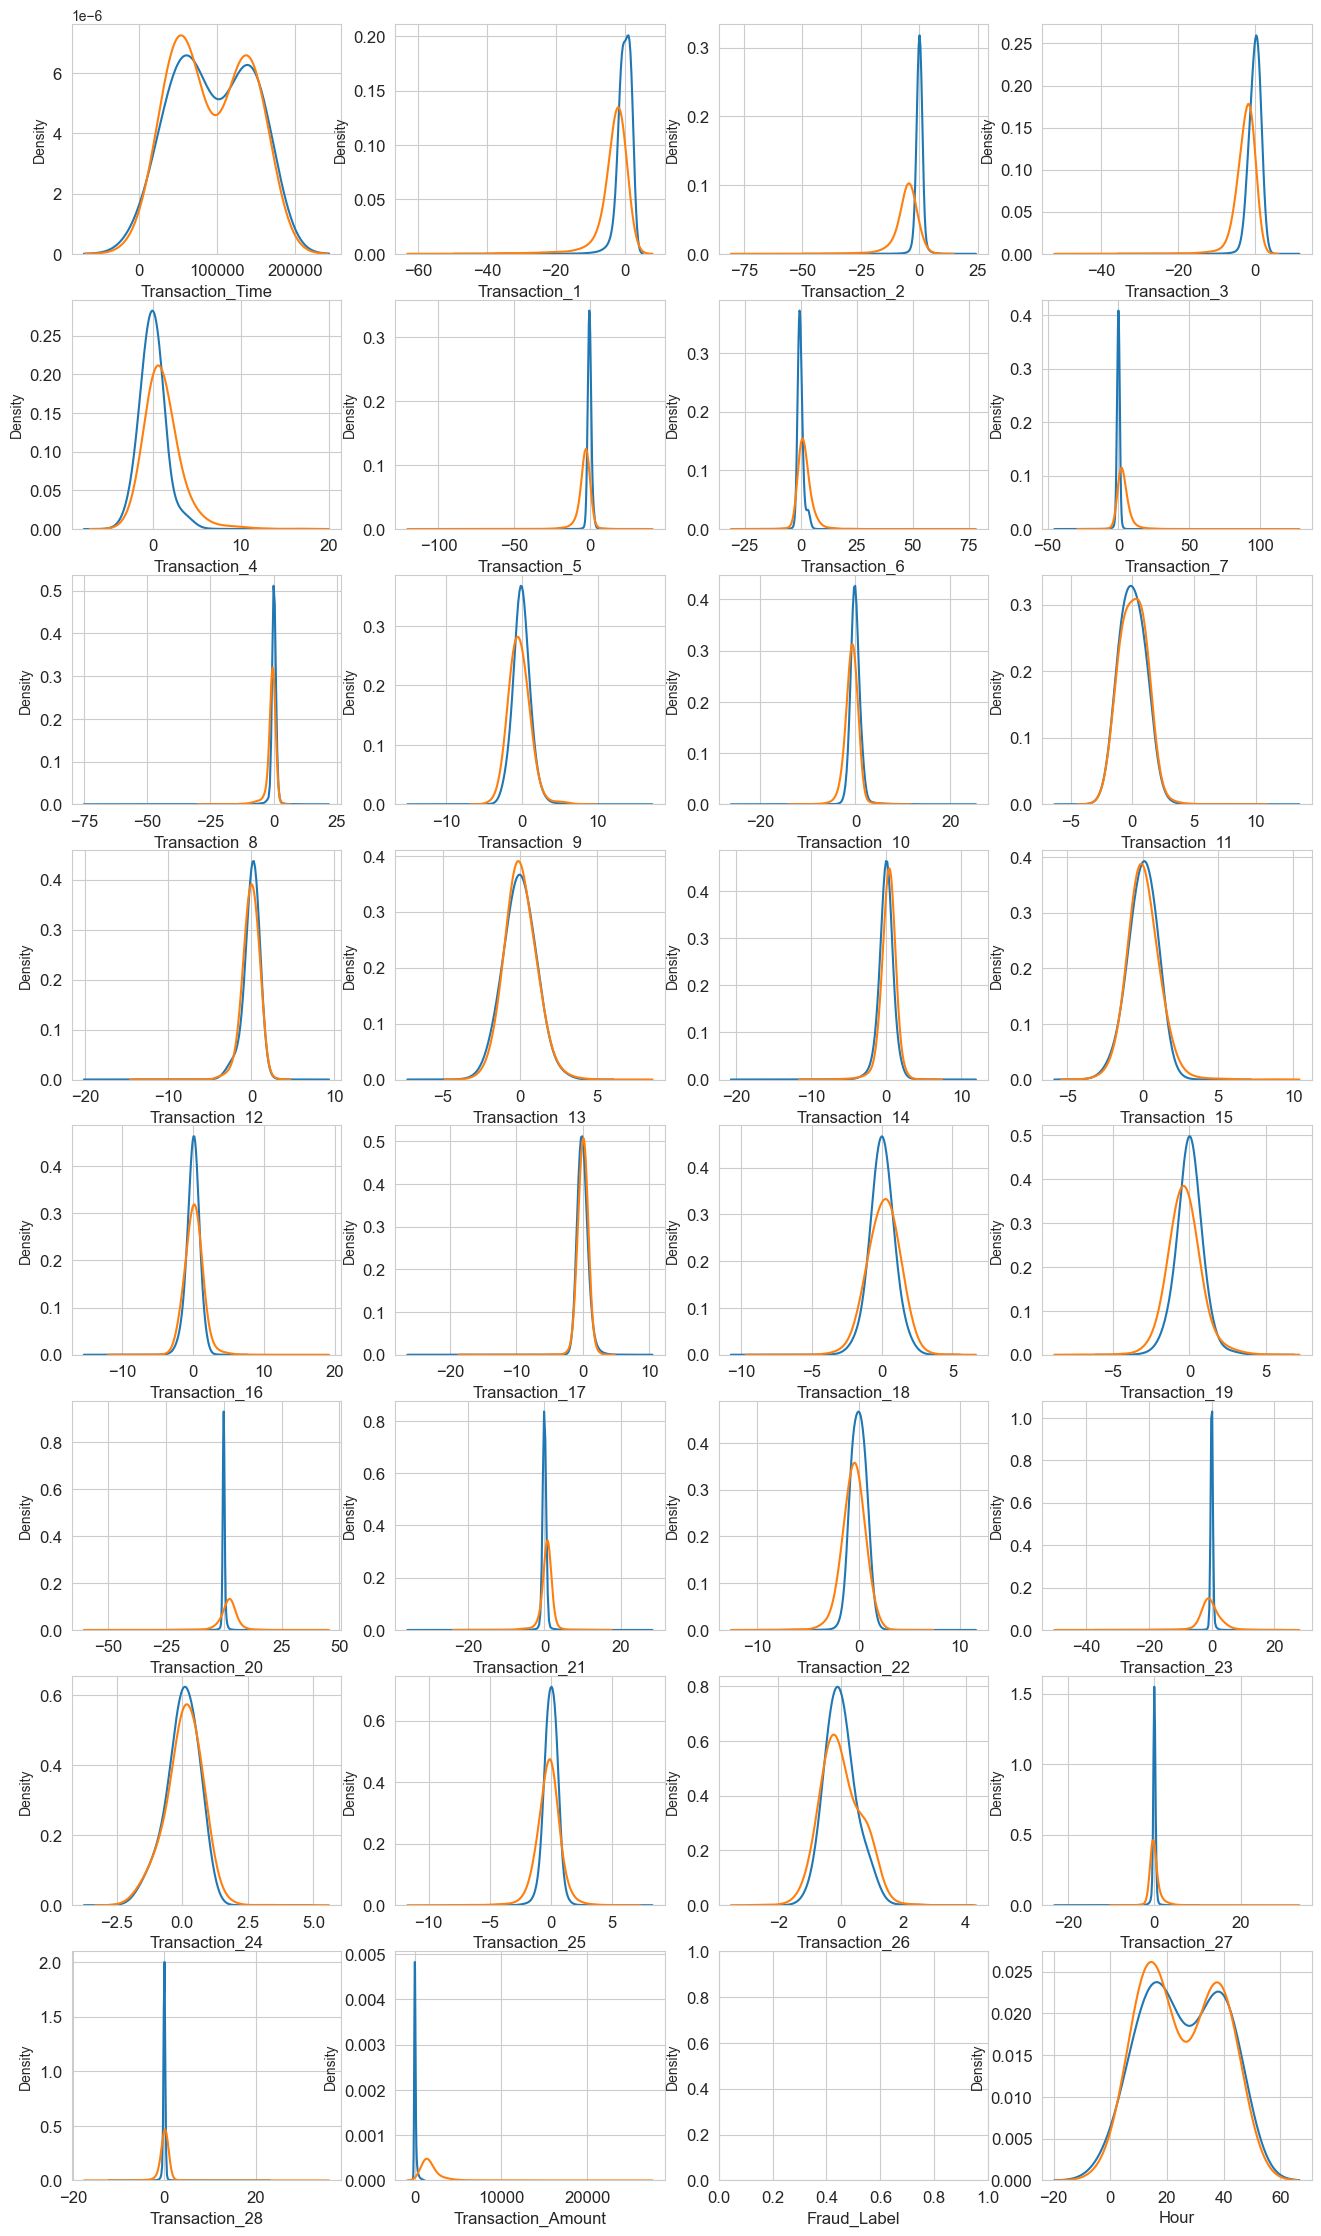

In [19]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Fraud_Label'] == 0]
t1 = data_df.loc[data_df['Fraud_Label'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Fraud_Label = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Fraud_Label = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of **Class**: **V4**, **V11** have clearly separated distributions for **Class** values 0 and 1, **V12**, **V14**, **V18** are partially separated, **V1**, **V2**, **V3**, **V10** have a quite distinct profile, whilst **V25**, **V26**, **V28** have similar profiles for the two values of **Class**.  

In general, with just few exceptions (**Time** and **Amount**), the features distribution for legitimate transactions (values of **Class = 0**)  is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of **Class = 1**) have a skewed (asymmetric) distribution.

# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [20]:
target = 'Fraud_Label'
predictors = ['Transaction_Time', 'Transaction_1', 'Transaction_2', 'Transaction_3', 'Transaction_4', 'Transaction_5', 'Transaction_6', 'Transaction_7', 'Transaction_8', 'Transaction_9', 'Transaction_10',\
       'Transaction_11', 'Transaction_12', 'Transaction_13', 'Transaction_14', 'Transaction_15', 'Transaction_16', 'Transaction_17', 'Transaction_18', 'Transaction_19',\
       'Transaction_20', 'Transaction_21', 'Transaction_22', 'Transaction_23', 'Transaction_24', 'Transaction_25', 'Transaction_26', 'Transaction_27', 'Transaction_28',\
       'Transaction_Amount']

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [22]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

Let's start with a RandomForrestClassifier <a href='#8'>[3]</a>   model.

## <a id="61">RandomForestClassifier</a>


### Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation. 

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#8'>[4]</a>.  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [23]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [24]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the **target** values for the **valid_df** data, using **predict** function.

In [25]:
preds = clf.predict(valid_df[predictors])

Let's also visualize the features importance.

### Features importance

C:\Users\NIKITA\AppData\Local\Temp\ipykernel_7224\990611410.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



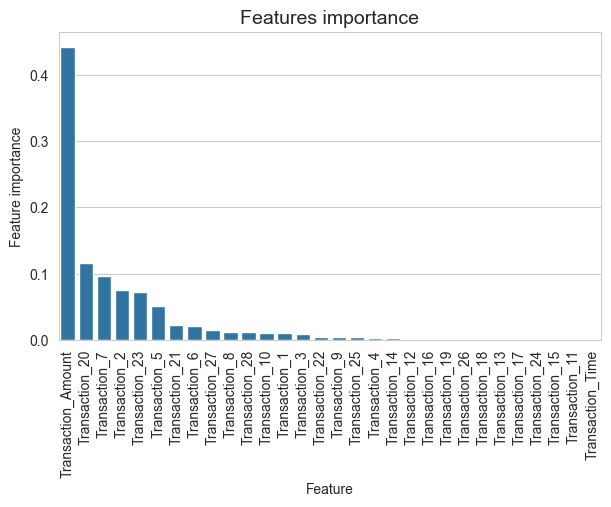

In [32]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()
 


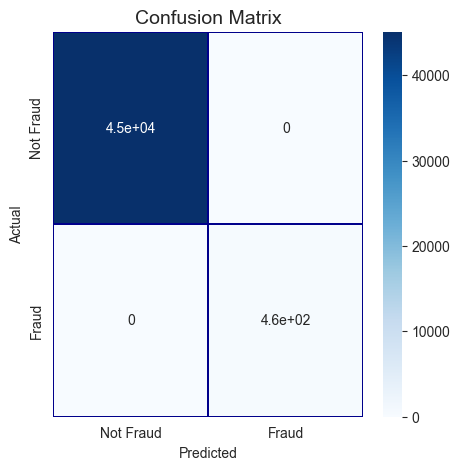

In [26]:

preds = clf.predict(valid_df[predictors])

# Now the confusion matrix should work
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

# Plotting confusion matrix
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, ax=ax1,
            linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [27]:
# Save the trained model to a .pkl file
with open('fraud_detection_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

with open('fraud_detection_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

The most important features are **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

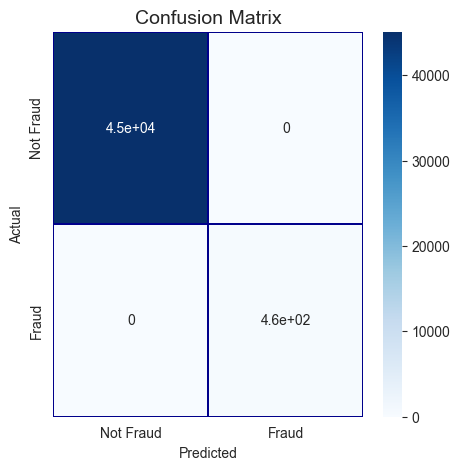

In [28]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

### Type I error and Type II error

We need to clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, because we will actually need a different metrics that accounts in the same time for the **selectivity** and **specificity** of the method we are using, so that we minimize in the same time both **Type I errors** and **Type II errors**.


**Null Hypothesis** (**H0**) - The transaction is not a fraud.  
**Alternative Hypothesis** (**H1**) - The transaction is a fraud.  

**Type I error** - You reject the null hypothesis when the null hypothesis is actually true.  
**Type II error** - You fail to reject the null hypothesis when the the alternative hypothesis is true.  

**Cost of Type I error** - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.  
**Cost of Type II error** - You erroneously presume that the transaction is not a fraud and a ffraudulent transaction is accepted.  

The following image explains what **Type I error** and **Type II error** are:    


<img src="https://i.stack.imgur.com/x1GQ1.png" width="600"/>

And this alternative image explains even better:  

<img src="https://i2.wp.com/flowingdata.com/wp-content/uploads/2014/05/Type-I-and-II-errors1.jpg" width="600"/>



Let's calculate the ROC-AUC score <a href='#8'>[4]</a>.

### Area under curve

In [35]:
roc_auc_score(valid_df[target].values, preds)

1.0

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.85**.





## <a id="63">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [29]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model. 

In [30]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

C:\Users\NIKITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning:

Pass `evals` as keyword args.

C:\Users\NIKITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\callback.py:386: UserWarning:

[19:08:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.




[0]	train-auc:0.99939	valid-auc:0.99927
[50]	train-auc:0.99990	valid-auc:0.99987
[100]	train-auc:0.99992	valid-auc:0.99989
[150]	train-auc:0.99995	valid-auc:0.99990
[200]	train-auc:0.99997	valid-auc:0.99991
[250]	train-auc:0.99998	valid-auc:0.99992
[300]	train-auc:0.99998	valid-auc:0.99992
[350]	train-auc:0.99999	valid-auc:0.99992
[400]	train-auc:0.99999	valid-auc:0.99993
[450]	train-auc:0.99999	valid-auc:0.99993
[500]	train-auc:0.99999	valid-auc:0.99993
[550]	train-auc:1.00000	valid-auc:0.99993
[600]	train-auc:1.00000	valid-auc:0.99993
[636]	train-auc:1.00000	valid-auc:0.99993


The best validation score (ROC-AUC) was **0.984**, for round **241**.

### Plot variable importance

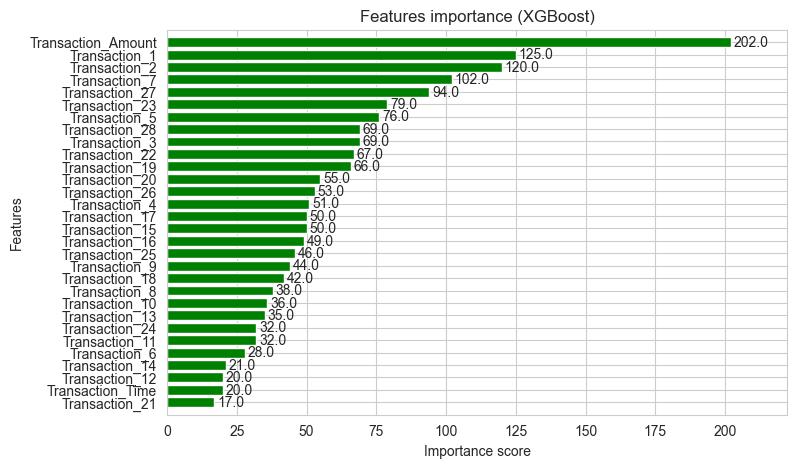

In [38]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### Predict test set


We used the train and validation sets for training and validation. We will use the trained model now to predict the target value for the test set.

In [31]:
from xgboost import XGBClassifier

# Initialize the model
model = XGBClassifier()

# Train it
model.fit(train_df[predictors], train_df[target].values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
# preds = model.predict(dtest)
preds = model.predict(test_df[predictors])

In [34]:
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Load the model back (optional, just to test)
with open('xgboost_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)


### Area under curve

Let's calculate ROC-AUC.

In [35]:
roc_auc_score(test_df[target].values, preds)

0.9807656056298307

The AUC score for the prediction of fresh data (test set) is **0.974**.

## <a id="64">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[8]</a> <a href='#8'>[9]</a>.


### Define model parameters

Let's set the parameters for the model. We will use these parameters only for the first lgb model.

In [36]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # Correct
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 7,
    'max_depth': 4,
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 150,  # because data is imbalanced
}

### Prepare the model

Let's prepare the model, creating the **Dataset**s data structures from the train and validation sets.

In [37]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Run the model

Let's run the model, using the **train** function.

In [38]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  # evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  # early_stopping_rounds=2*EARLY_STOP,
                  # verbose_eval=VERBOSE_EVAL, 
                  feval=None)


Best validation score  was obtained for round **85**, for which **AUC ~= 0.974**.

Let's plot variable importance.

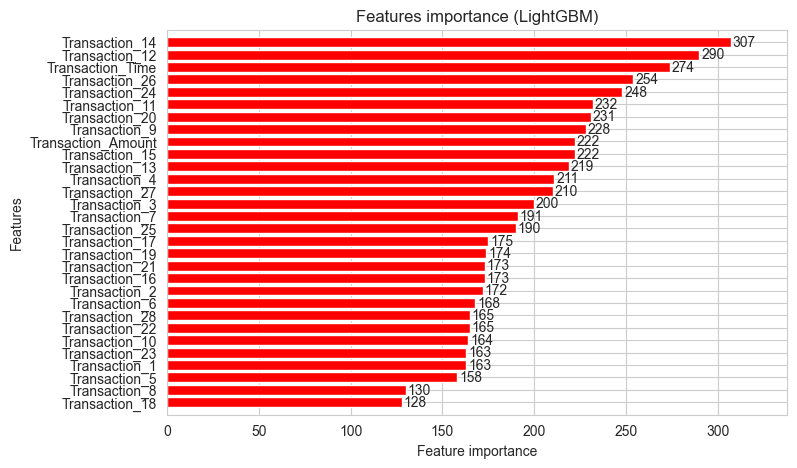

In [55]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

Let's predict now the target for the test data.

### Predict test data

In [39]:
preds = model.predict(test_df[predictors])

### Area under curve

Let's calculate the ROC-AUC score for the prediction.

In [40]:
roc_auc_score(test_df[target].values, preds)

0.9998889715200197

The ROC-AUC score obtained for the test set is **0.946**.

In [41]:
# Save LightGBM model
with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [58]:
columns = data_df.columns
print(columns)

Index(['Transaction_Time', 'Transaction_1', 'Transaction_2', 'Transaction_3',
       'Transaction_4', 'Transaction_5', 'Transaction_6', 'Transaction_7',
       'Transaction_8', 'Transaction_9', 'Transaction_10', 'Transaction_11',
       'Transaction_12', 'Transaction_13', 'Transaction_14', 'Transaction_15',
       'Transaction_16', 'Transaction_17', 'Transaction_18', 'Transaction_19',
       'Transaction_20', 'Transaction_21', 'Transaction_22', 'Transaction_23',
       'Transaction_24', 'Transaction_25', 'Transaction_26', 'Transaction_27',
       'Transaction_28', 'Transaction_Amount', 'Fraud_Label', 'Hour'],
      dtype='object')


In [66]:
# 2. Prepare data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
predictors = [
    'Transaction_Time','Transaction_1', 'Transaction_2', 'Transaction_3', 'Transaction_4', 'Transaction_5',
    'Transaction_6', 'Transaction_7', 'Transaction_8', 'Transaction_9', 'Transaction_10',
    'Transaction_11', 'Transaction_12', 'Transaction_13', 'Transaction_14', 'Transaction_15',
    'Transaction_16', 'Transaction_17', 'Transaction_18', 'Transaction_19', 'Transaction_20',
    'Transaction_21', 'Transaction_22', 'Transaction_23', 'Transaction_24', 'Transaction_25',
    'Transaction_26', 'Transaction_27', 'Transaction_28','Transaction_Amount'
]
# predictors = [col for col in data_df.columns if col != target]
target = 'Fraud_Label'

X = data_df[predictors]
y = data_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Initialize and Train
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# 4. Predict
y_pred = dt_model.predict(X_test)

# 5. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 6. Save
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)
roc_auc_score(test_df[target].values,y_pred)

Accuracy: 1.0
Confusion Matrix:
 [[56377     0]
 [    0   585]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56377
           1       1.00      1.00      1.00       585

    accuracy                           1.00     56962
   macro avg       1.00      1.00      1.00     56962
weighted avg       1.00      1.00      1.00     56962



0.499159349252829

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

Test set is calculated as an average of the predictions 

In [58]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx],train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx],train_df[target].iloc[valid_idx]
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  # verbose=-1,
                  feval=None)
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc')
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold = n_fold + 1
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print('Full AUC score %.6f' % train_auc_score)                                    

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

The AUC score for the prediction from the test data was 0.93.

We prepare the test prediction, from the averaged predictions for test over the 5 folds.

In [59]:
pred = test_preds

# <a id="7">Conclusions</a>

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. 
We then investigated two predictive models. The data was split in 3 parts, a train set, a validation set and a test set. For the first three models, we only used the train and test set.  

We started with **RandomForrestClassifier**, for which we obtained an AUC scode of **0.85** when predicting the target for the test set.  

We followed with an **AdaBoostClassifier** model, with lower AUC score (**0.83**) for prediction of the test set target values.    

We then followed with an **CatBoostClassifier**, with the AUC score after training 500 iterations **0.86**.    

We then experimented with a **XGBoost** model. In this case, se used the validation set for validation of the training model.  The best validation score obtained was   **0.984**. Then we used the model with the best training step, to predict target value from the test data; the AUC score obtained was **0.974**.

We then presented the data to a **LightGBM** model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict 'Class' value, i.e. detecting if a transaction was fraudulent. With the first method we obtained values of AUC for the validation set around **0.974**. For the test set, the score obtained was **0.946**.   
With the cross-validation, we obtained an AUC score for the test prediction of  **0.93**.

# <a id="8">References</a>

[1] Credit Card Fraud Detection Database, Anonymized credit card transactions labeled as fraudulent or genuine, https://www.kaggle.com/mlg-ulb/creditcardfraud  
[2] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[3] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[5] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
[6] CatBoostClassifier, https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
[7] XGBoost Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
[8] LightGBM Python implementation, https://github.com/Microsoft/LightGBM/tree/master/python-package  
[9] LightGBM algorithm, https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf   

